Data from: https://github.com/ravsimar-sodhi/jibes-and-delights

In [24]:
import string
import os
import signal
interrupt = [False]

def sig_handler(signum, frame):
    interrupt[0] = True
    
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [22]:
files = ['comment.dev.0', 'comment.test.0', 'comment.train.0']

text = []
for f in files:
    with open(f, 'r') as iofile:
        text += iofile.readlines()

print(len(text))
print(text[0])

68159
During inclement weather does your hair function as a umbrella?



In [23]:
text = [line.lower() for line in text]
print(len(text))
print(text[0])

68159
during inclement weather does your hair function as a umbrella?



In [35]:
print(min([len(line) for line in text]))

17


In [26]:
tokens = sorted(set(''.join(text)))
print(tokens)

['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', '[', '\\', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '~', '£', '©', '®', '°', '´', 'â', 'ä', 'æ', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'ñ', 'ö', 'ü', 'ʖ', '͜', '͠', '͡', 'ε', 'π', 'б', 'е', 'ж', 'й', 'м', 'о', 'ل', '–', '—', '‘', '’', '“', '”', '…', '™', '★', '☑', '♥', '♪', '✄', '✅', '✓', '✔', '⬇', '️', '￼', '🌚', '🍄', '🎳', '🏇', '👏', '💕', '💩', '😂', '😃', '😈', '😜']


In [25]:
class RecurrentNeuralNetwork(nn.Module):
    def __init__(self, tokens, embedding_size=16, hidden_dim_size=64, num_layers=1):
        super(self.__class__,self).__init__()
        self.tokens = tokens
        self.token_to_id = dict([(y, x) for (x, y) in enumerate(self.tokens, 0)])
        self.id_to_token = dict(enumerate(self.tokens, 0))
        
        self.embedding = nn.Embedding(len(self.tokens), embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_dim_size, num_layers=num_layers, batch_first=True)
        self.rnn_to_logits = nn.Linear(hidden_dim_size, len(self.tokens))
    
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.embedding(x))
        next_logits = self.rnn_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

In [27]:
model = RecurrentNeuralNetwork(tokens, 50, 250, 4)

In [28]:
opt = torch.optim.Adam(model.parameters())
loss = nn.NLLLoss()

In [29]:
history_model = []

In [32]:
dataloader = torch.utils.data.DataLoader([[model.token_to_id[char] for char in line] for line in text], batch_size=64, shuffle=True)

In [33]:
interrupt = [False]
signal.signal(signal.SIGINT, sig_handler)
while not interrupt[0]:
    for data in dataloader:
        opt.zero_grad()
        batch_ix = torch.stack(data).transpose(0, 1)

        logp_seq = model(batch_ix)

        predictions_logp = logp_seq[:, :-1].reshape(-1, len(tokens))
        actual_next_tokens = batch_ix[:, 1:].reshape(-1)

        loss_res = loss(predictions_logp, actual_next_tokens)

        # train with backprop
        loss_res.backward()
        opt.step()
    
    history_model.append(loss_res.data)
    clear_output(True)
    plt.figure(figsize=(18,6))
    plt.plot(history_model,label='loss')
    plt.legend()
    plt.show()
print('Done')

RuntimeError: each element in list of batch should be of equal size

In [38]:
new_text = ''.join(text)
print(len(new_text))

5517989


In [36]:
class RecurrentNeuralNetwork():
    def __init__(self, text, embedding_size=16, hidden_dim_size=64, num_layers=1):
        class LSTM_RNN(nn.Module):
            def __init__(self, vocab_size, embedding_size, hidden_dim_size):
                super(self.__class__,self).__init__()
                self.embedding = nn.Embedding(vocab_size, embedding_size)
                self.rnn = nn.LSTM(embedding_size, hidden_dim_size, num_layers=num_layers, batch_first=True)
                self.rnn_to_logits = nn.Linear(hidden_dim_size, vocab_size)

            def forward(self, x):
                assert isinstance(x.data, torch.LongTensor)
                h_seq, _ = self.rnn(self.embedding(x))
                next_logits = self.rnn_to_logits(h_seq)
                next_logp = F.log_softmax(next_logits, dim=-1)
                return next_logp
        self.text = ''.join(text).lower()
        self.tokens = sorted(set(self.text))
        self.token_to_id = dict([(y, x) for (x, y) in enumerate(self.tokens, 0)])
        self.id_to_token = dict(enumerate(self.tokens, 0))
        self.model = LSTM_RNN(len(self.tokens), embedding_size, hidden_dim_size)
        self.opt = torch.optim.Adam(self.model.parameters())
        self.loss = nn.NLLLoss()
    
    def train_cycle(self, data_loader, history):
        for data in data_loader:
            self.opt.zero_grad()
            batch_ix = torch.stack(data).transpose(0, 1)

            logp_seq = self.model(batch_ix)

            predictions_logp = logp_seq[:, :-1].reshape(-1, len(self.tokens))
            actual_next_tokens = batch_ix[:, 1:].reshape(-1)

            loss = self.loss(predictions_logp, actual_next_tokens)

            # train with backprop
            loss.backward()
            self.opt.step()
        history.append(loss.data)
        
    def generate_sample(self, seed_phrase, length=100, temperature=1.0):
        x_sequence = [self.token_to_id[char] for char in seed_phrase]
        x_sequence = torch.tensor([x_sequence])

        while x_sequence[-1] != '\n' and len(x_sequence) < lenght:
            out = self.model(x_sequence)[:, -1, :]
            p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]

            next_ix = np.random.choice(len(self.tokens), p=p_next)
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
            x_sequence = torch.cat([x_sequence, next_ix], dim=1)

        return ''.join([self.id_to_token[ix] for ix in x_sequence.data.numpy()[0]])

In [37]:
class TextDataset(torch.utils.data.IterableDataset):
    def __init__(self, model, seq_length, step=1):
        self.text = [model.token_to_id[char] for char in model.text]
        self.seq_length = seq_length
        self.step =step
    
    def __iter__(self):
        self.idx = -self.step
        return self
    
    def __next__(self):
        self.idx += self.step
        if self.idx <= len(self.text) - seq_length:
            return self.text[self.idx : self.idx + seq_length]
        else:
            raise StopIteration

seq_length = 16
step = 16

In [39]:
model = RecurrentNeuralNetwork(text=text, embedding_size=50, hidden_dim_size=250, num_layers=4)

In [40]:
data_loader = torch.utils.data.DataLoader(TextDataset(model, seq_length, step), batch_size=32)

In [41]:
history_model = []

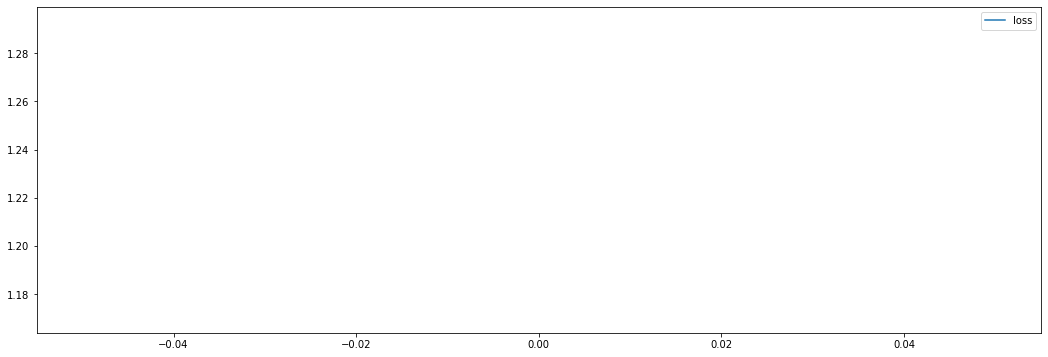

Done


In [42]:
interrupt = [False]
signal.signal(signal.SIGINT, sig_handler)
while not interrupt[0]:
    model.train_cycle(data_loader, history_model)
    clear_output(True)
    plt.figure(figsize=(18,6))
    plt.plot(history_model,label='loss')
    plt.legend()
    plt.show()
print('Done')

In [50]:
def generate_sample(model, seed_phrase, length=100, temperature=1.0):
    x_sequence = [model.token_to_id[char] for char in seed_phrase]
    x_sequence = torch.tensor([x_sequence])

    while x_sequence[-1] != '\n' and len(x_sequence) < length:
        out = model.model(x_sequence)[:, -1, :]
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]

        next_ix = np.random.choice(len(model.tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        print(model.id_to_token[next_ix])

    return ''.join([model.id_to_token[ix] for ix in x_sequence.data.numpy()[0]])

In [51]:
generate_sample(model, 'you ', length=10)

KeyError: tensor([[43]])

In [4]:
class RecurrentNeuralNetwork(nn.Module):
    def __init__(self, tokens, embedding_size=16, hidden_dim_size=64, num_layers=1):
        super(self.__class__,self).__init__()
        self.tokens = tokens
        self.token_to_id = dict([(y, x) for (x, y) in enumerate(self.tokens, 0)])
        self.id_to_token = dict(enumerate(self.tokens, 0))
        
        self.embedding = nn.Embedding(len(self.tokens), embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_dim_size, num_layers=num_layers, batch_first=True)
        self.rnn_to_logits = nn.Linear(hidden_dim_size, len(self.tokens))
    
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.embedding(x))
        next_logits = self.rnn_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

In [ ]:
class TextDataset(torch.utils.data.IterableDataset):
    def __init__(self, model, seq_length, step=1):
        self.text = [model.token_to_id[char] for char in model.text]
        self.seq_length = seq_length
        self.step =step
    
    def __iter__(self):
        self.idx = -self.step
        return self
    
    def __next__(self):
        self.idx += self.step
        if self.idx <= len(self.text) - seq_length:
            return self.text[self.idx : self.idx + seq_length]
        else:
            raise StopIteration


seq_length = 16
step = 16
data_loader = torch.utils.data.DataLoader(TextDataset(new_model, seq_length, step), batch_size=32)

In [ ]:
model = RecurrentNeuralNetwork(...)

In [ ]:
opt = torch.optim.Adam(model.parameters())
loss = nn.NLLLoss()

def train_cycle(model, opt, loss, data_loader, history):
    for data in data_loader:
        opt.zero_grad()
        batch_ix = torch.stack(data).transpose(0, 1)

        logp_seq = model(batch_ix)

        predictions_logp = logp_seq[:, :-1].reshape(-1, len(model.tokens))
        actual_next_tokens = batch_ix[:, 1:].reshape(-1)

        loss_res = loss(predictions_logp, actual_next_tokens)

        # train with backprop
        loss_res.backward()
        opt.step()
    history.append(loss_res.data)

def generate_sample(model, seed_phrase, temperature=1.0):
    x_sequence = [model.token_to_id[char] for char in seed_phrase]
    x_sequence = torch.tensor([x_sequence])

    while x_sequence[-1] != '\n':
        out = model(x_sequence)[:, -1, :]
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]

        next_ix = np.random.choice(len(model.tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([model.id_to_token[ix] for ix in x_sequence.data.numpy()[0]])